# Download a S&P 500 data set

In this repository we will use the historical daily closing prices of the S&P 500. The data was downloaded from https://stooq.com/q/d/?s=^spx. You can download it yourself under the following link of execute the cell below.

In [11]:
!curl 'https://stooq.com/q/d/l/?s=^spx&i=d&c=1' \
  -H 'Connection: keep-alive' \
  -H 'Upgrade-Insecure-Requests: 1' \
  -H 'User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.87 Safari/537.36' \
  -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'Sec-GPC: 1' \
  -H 'Sec-Fetch-Site: none' \
  -H 'Sec-Fetch-Mode: navigate' \
  -H 'Sec-Fetch-User: ?1' \
  -H 'Sec-Fetch-Dest: document' \
  -H 'Accept-Language: en-US,en;q=0.9,de-DE;q=0.8,de;q=0.7' \
  --compressed > data/spx.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1532k    0 1532k    0     0   765k      0 --:--:--  0:00:02 --:--:--  765k


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data for analysis

In [14]:
DATE_DAILY = pd.Timestamp(1885, 2, 1)

daily_data = pd.read_csv('data/spx.csv', parse_dates=['Date'], infer_datetime_format=True, sep=';')
daily_data = daily_data[daily_data['Date'] > DATE_DAILY]
daily_data.head()

,Date,Open,High,Low,Close,Volume
1150,1885-02-17,4.37,4.37,4.37,4.37,NaN
1151,1885-02-18,4.39,4.39,4.39,4.39,NaN
1152,1885-02-19,4.42,4.42,4.42,4.42,NaN
1153,1885-02-20,4.38,4.38,4.38,4.38,NaN
1154,1885-02-21,4.45,4.45,4.45,4.45,NaN


In [15]:
daily_data.to_csv('data/spx_day.csv')

# Some general anlyses on the S&P 500 data

In [16]:
weekly_data = daily_data.resample('W', on='Date').mean()
monthly_data = daily_data.resample('BM', on='Date').mean()
quarterly_data = daily_data.resample('BQ', on='Date').mean()
yearly_data = daily_data.resample('BA', on='Date').mean()

In [17]:
for df, timeframe in [(daily_data, "day"), (weekly_data, "week"), (monthly_data, "month"), (quarterly_data, "quater"), (yearly_data, "year")]:
    df['change_percent'] = df['Close'].pct_change()
    df['SMA_3'] = df['Close'].rolling(3).mean()
    df['SMA_10'] = df['Close'].rolling(30).mean()
    df['SMA_50'] = df['Close'].rolling(300).mean()

The first interesting question to consider is whether the S&P 500 has a positive expected return in the long run.
Only the does it make sense too consider it the a Kelly Criterion based strategy.

In [18]:
returns = pd.DataFrame()
returns['year'] = yearly_data['change_percent'].describe()
returns['quarter'] = quarterly_data['change_percent'].describe()
returns['month'] = monthly_data['change_percent'].describe()
returns['week'] = weekly_data['change_percent'].describe()
returns['day'] = daily_data['change_percent'].describe()
returns

,year,quarter,month,week,day
count,138.000000,552.000000,1655.000000,7194.000000,37703.000000
mean,0.061517,0.014940,0.004987,0.001139,0.000236
std,0.153220,0.071596,0.042436,0.019834,0.010565
min,-0.493300,-0.331988,-0.264664,-0.194315,-0.204669
25%,-0.036763,-0.026059,-0.015171,-0.008732,-0.004338
50%,0.071060,0.017634,0.007453,0.002566,0.000315
75%,0.168916,0.057625,0.028832,0.012064,0.005102
max,0.458966,0.336118,0.508160,0.185413,0.166096


We see that the S&P 500 has a yearly average return of 6.3%. The worst year-to-year return was -49% in 1932 and the highest year-to-year return was 45% in 1936. Below is a historical plot of year-to-year returns.

Text(0.5, 0, 'Yearly change in percent')

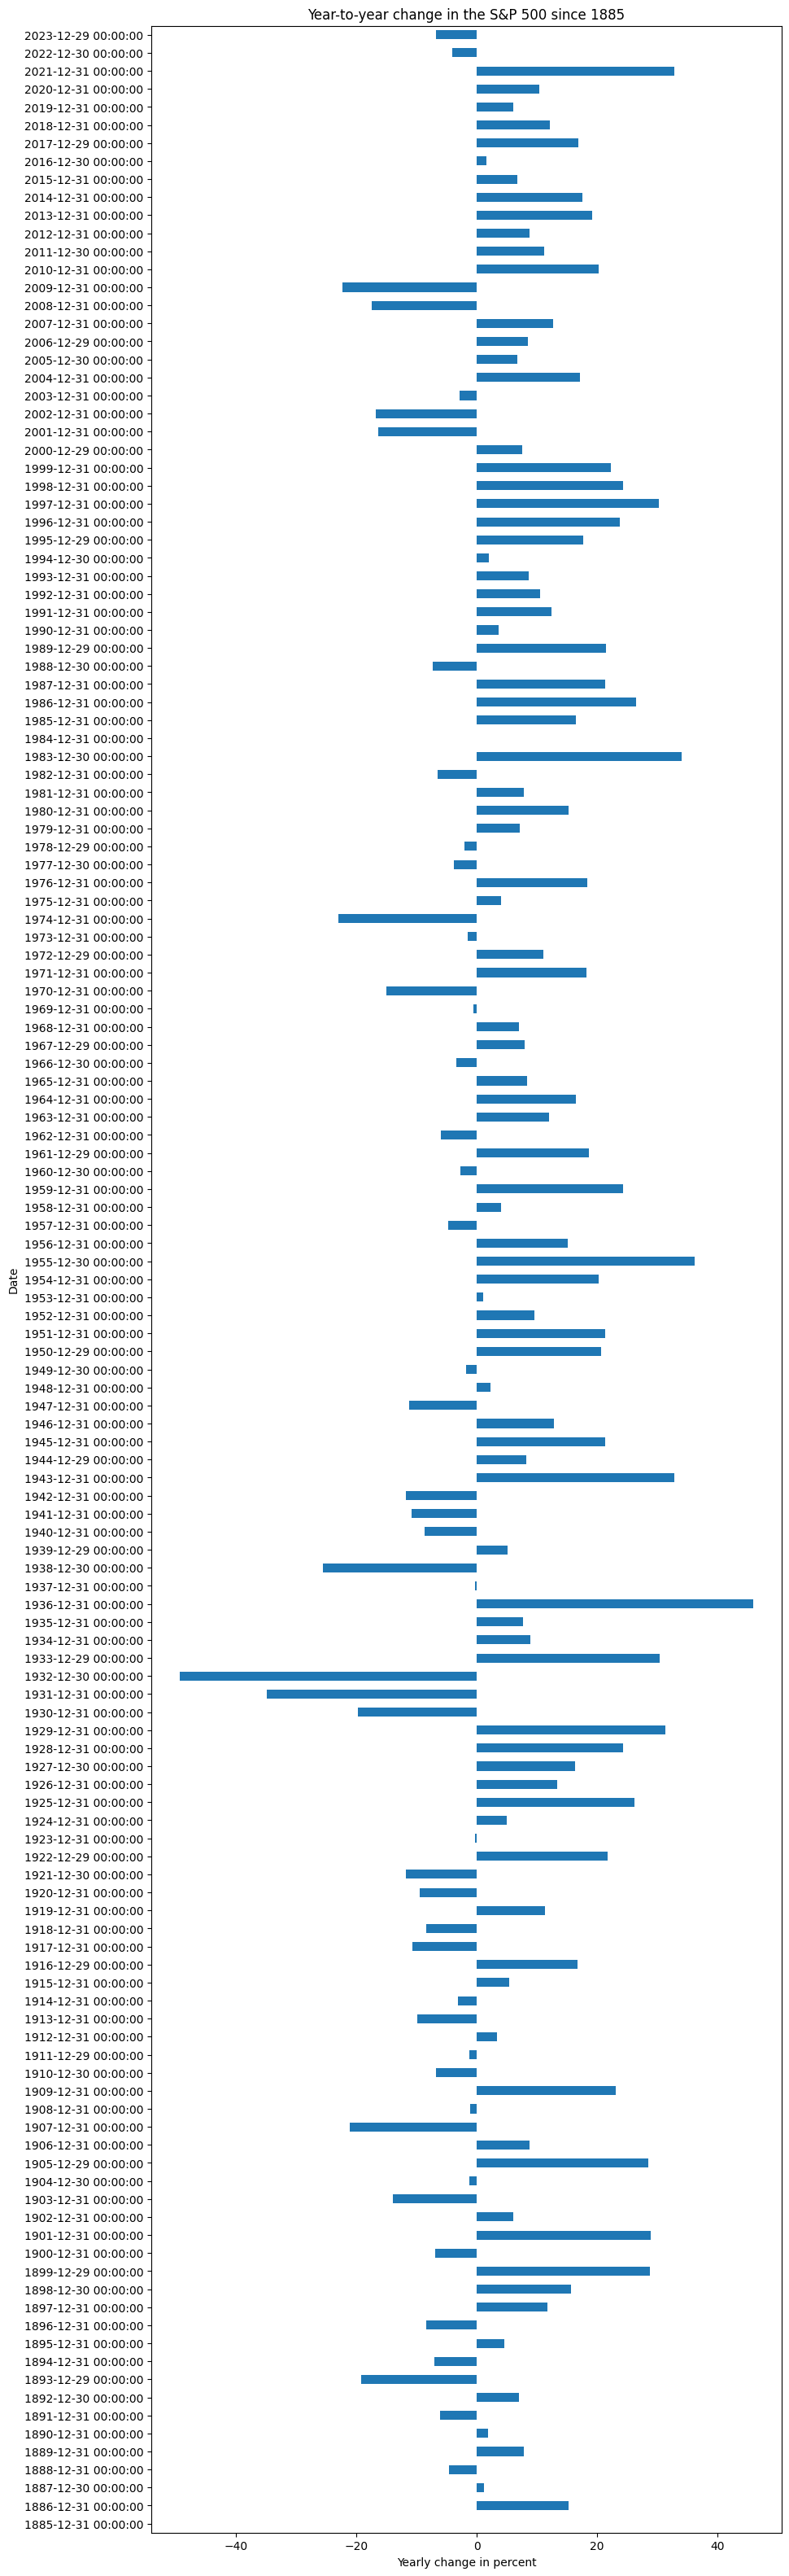

In [19]:
yearly_change = yearly_data['change_percent'] * 100.0

fig, ax = plt.subplots(figsize=(10, 40))
yearly_change.plot.barh(y='change_percent', figsize=(10, 40), title='Year-to-year change in the S&P 500 since 1885')

ax.set_xlabel('Yearly change in percent')


Now let's see how the returns are distributed. A huge one-time gain that is compensated by many small losses is not desirable for a strategy of continuous small bets. Ideally we want the distribution of positive returns to be greater than the distribution of negative returns.

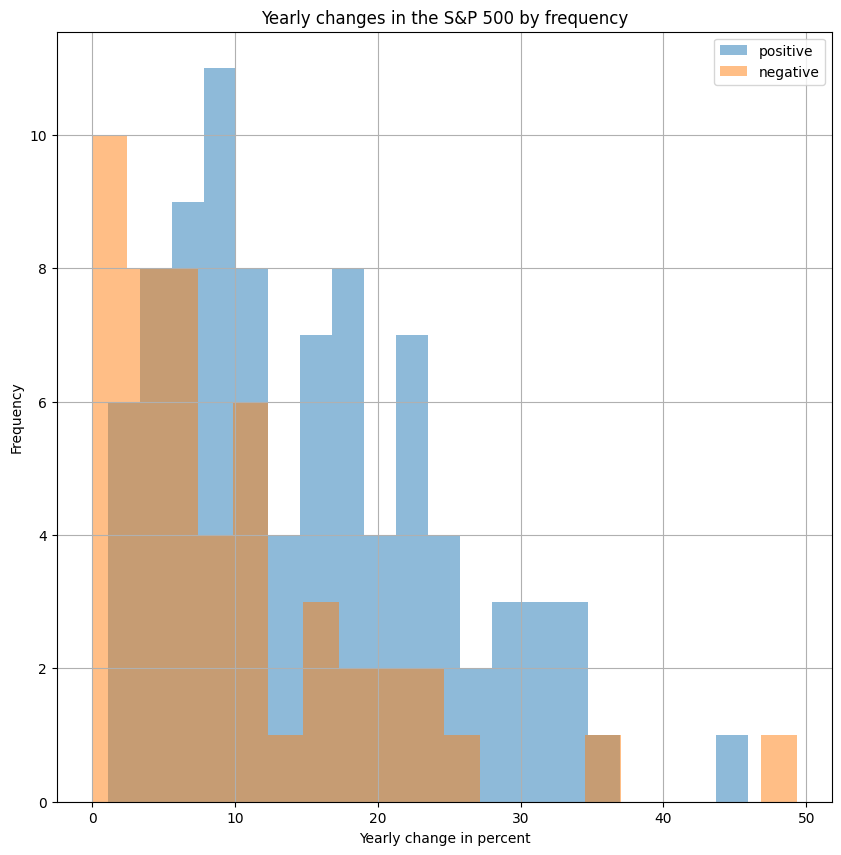

In [20]:
yearly_positive = yearly_data[yearly_data['change_percent'] > 0]['change_percent'] * 100.0
yearly_negative = yearly_data[yearly_data['change_percent'] < 0]['change_percent'] * -100.0

fig, ax = plt.subplots(figsize=(10, 10))
yearly_positive.hist(bins=20, figsize=(10, 10), alpha=0.5, label='positive')
yearly_negative.hist(bins=20, figsize=(10, 10), alpha=0.5, label='negative')

ax.set_xlabel('Yearly change in percent')
ax.set_ylabel('Frequency')
ax.set_title('Yearly changes in the S&P 500 by frequency')
ax.legend()